<a href="https://colab.research.google.com/github/AhmedHany8/Supervised_Machine_Learning/blob/main/HeadPoseEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**HEAD POSE ESTIMATION PROJECT**
---
<font color='green' ><b>TIP you can estimate the head pose using mediapipe and openCV only.</b></font><br>
<font color='green'>---------------------------------------------------------------------------------------------------------------------</font><br>

**Project objective**

> **predict the head pose** from an image by using supervised machine learning algorithms.

```
Project Pipeline:

  1. reading the dataset.

  2. apply mediapipe on each image and take (x,y) only.

  3. rescale the mediapipe landmarks to the image pexils.

  4. normalize landmark's values to be relative to the face
     and not get affected by the face position on the image.

  5.get the labels of each image. (pitch, yaw, roll) from the'.mat' files.

  6. make a dataframe for features (number_of_images * number_of_features),
    'hint' number of features = number of mediapipe landmarks * 2.

  7. split the data into 80% train and 20% validation and randomize the data.

  8. train multiple models to get the best one of them
     which has the least Mean Absolute Error among them.

  9. draw the 3 axes on the image by passing the image path.

  10. draw the 3 axes on the video by passing the video path.
```
># Thanks to:
>>*   **Eng. Amira Adel Foda**
>>*   **Eng. Asmaa Said**
>>*   **Eng. Marawan Mohamed**
><h6>for providing helpful file for reading and plotting the data. <font color = 'red'>-> <a href="https://github.com/s7s/machine_learning_1/blob/master/ML_in_practice/ProjectHelper.ipynb">GitHub Repository</a>


># Spicial Thanks to my Instructor:
>>*   **Eng. Mohamed Hussien**
><h6>for simplifing the topics of supervised machine learning and providing good explination for each algorithm in how it works from 2 differnt points of view (Algorithm, Mathematics). <font color = 'red'>-> <a href="https://github.com/s7s">Instructor GitHub Profile</a>

># Cridits:
>>*   **Eng. Ahmed Hany**
><h6>Hope you find this notebook helpful and easy to read.<br>
Please, contact me <b>if you need any help</b> in this notebook. or even <b>if you have any improvements to apply on this problem</b>.<br>


*   <a href="https://github.com/AhmedHany8">GitHub Profile</a>
*   <a href="https://www.linkedin.com/in/ahmed-hany-99270318b/">LinkedIn Profile</a>
*   <a href="mailto: ahmedhanya1000@gmail.com">E-Mail</a>










# Importing the important libraries

In [1]:
# mediapipe for detect the face and generates the face points
!pip install mediapipe
import mediapipe

# to ddeal with the data faster than lists
import numpy as np

# dealing with images, get directories of dataset, randoize the data
import os,cv2, glob, random

# to plot images
from google.colab.patches import cv2_imshow

# to .mat files and retrieve the labels
import scipy.io as sio

# to draw the axes on the image
from math import cos, sin

# to remove the unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

# for splitting the data and apply gird search on models to find the best model
from sklearn.model_selection import train_test_split ,GridSearchCV

# to create clones of the same model for differnt labels
from sklearn.multioutput import MultiOutputRegressor

# i picked these models to choose the best one of them
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor

# i chose this loss function to determine the model's performance
from sklearn.metrics import mean_absolute_error

# for download the created video
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Retreving the dataset

In [18]:
if os.path.isfile('/content/drive/MyDrive/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
!unzip /content/drive/MyDrive/AFLW2000-3D.zip

Archive:  /content/drive/MyDrive/AFLW2000-3D.zip
replace AFLW2000/Code/DrawSolidHead.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Important functions for the application




1.   **Standrize the mediapipe points**

> *after investigating the point's indexes i have found:*


> > -> most top point index        = **10**

> > -> the best center point index =  **5**

> > -> least bottom point index    = **152**

> these points are on the same line and also splits the face perfectly and has the max distance over all the points.

> normalized_point = **(relative_point - center_point) / distance(top_point,bot_point)**

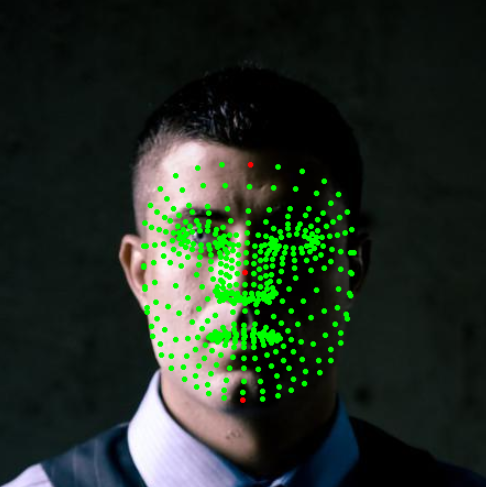

as we can see these 3 points are the best poition to scale the points on.


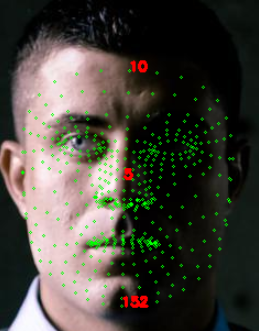

In [3]:
def mediapipe_relative2normalized(face_mesh_x,face_mesh_y):

  # centering the data arround the 5th point
  x_centered = face_mesh_x - face_mesh_x[5].reshape(-1,1)
  y_centered = face_mesh_y - face_mesh_y[5].reshape(-1,1)

  # getting the courdinates of the top point '10' and the bottom point '152'
  top_point = np.array((face_mesh_x[10],face_mesh_y[10]))
  bottom_point = np.array((face_mesh_x[152],face_mesh_y[152]))

  # computing the distance using the vector norm 'L2'
  distance = np.linalg.norm(top_point - bottom_point)

  # deviding the centerd array over the maximum distance to rescale the values between -1 and 1
  x_norm = x_centered / distance
  y_norm = y_centered / distance

  # concatinating 2 arrays to make 1 array holds all the features of the image
  features = np.hstack([x_norm,y_norm]).reshape(-1)

  return features


2.   **Detect the face mesh**

> *takes all the faces in the image and apply this for each point:*


> > -> appends the **x-axis** in face_mesh_x array

> > -> appends the **y-axis** in face_mesh_y array

> > -> removes the **z-axis** from the data

> these points are passed to **mediapipe_relative2normalized** function to get 1d array for the image.

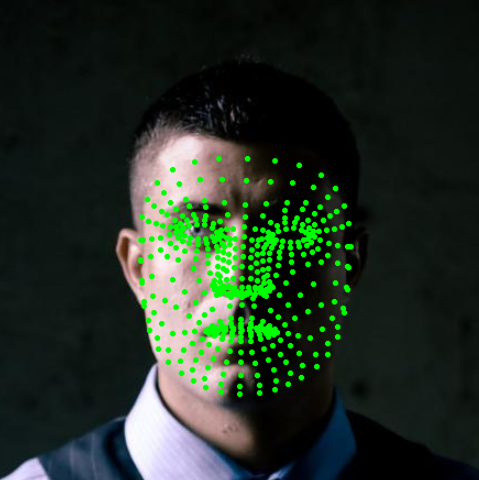

In [4]:
def mediapipe2array(image):

  # loading face_mesh model to extract the features from the image '468 point for each face'
  faceModule = mediapipe.solutions.face_mesh

  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:

    # 2 arrays saves each point value (x,y)
    face_mesh_x = []
    face_mesh_y = []

    # loading the image and retrieving the dimentions
    height, width, _ = image.shape

    # passing the image as RGB for the model to get the points x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # do nothing if the image has no faces
    if results.multi_face_landmarks == None: return np.array([]),0,0
    
    # looping over the faces in the image
    for face in results.multi_face_landmarks:

      # looping over the points on the face
      for landmark in face.landmark:

        # we will get the x,y axes only to apply the Machine learning to retrieve the 3 axes from only 2 axes (just for learning)
        # rescaling the points from mediapipe to the normal image size to know the courdinates of the point on the image
        relative_x = landmark.x * width
        relative_y = landmark.y * height

        # appending the values in arrays to apply preprocessing on them before making then 1 array
        face_mesh_x.append(relative_x)
        face_mesh_y.append(relative_y)

      # making sure that we have all the mediapipe points for each face
      if len(face_mesh_x) == 468:
        
        # converting the 2 arrays to numpy arrays
        face_mesh_x = np.array(face_mesh_x)
        face_mesh_y = np.array(face_mesh_y)

        # passing the 2 relative arrays to get normalized and concatinate them into 1-d array
        face_mesh_normalized_array = mediapipe_relative2normalized(face_mesh_x,face_mesh_y)

        # returns the normalized array with the center point
        return face_mesh_normalized_array, face_mesh_x[5], face_mesh_y[5]

      # do nothing if mediapipe couldn't detect all the points
      else: return np.array([]),0,0

# Loading the dataset into:

> Features DataFrame -> valid_images * 936 'Features'

> Labels DataFrame   -> valid_images *  3  'Labels'

In [5]:
def prepare_dataframes(dataset_name):

  # features DataFrame
  features = []

  # labels DataFrame
  labels = []

  # getting the directory of all the images in a single array
  images_dir = sorted(glob.glob(f"/content/{dataset_name}/*.jpg"))

  # looping over the dataset
  for dirc in images_dir:

    # normalize the image
    image = cv2.imread(dirc)
    preprocessed_image,_,_ = mediapipe2array(image)

    # taking only the images that has full points from mediapipe
    if len(preprocessed_image) == 936:

      # appending all the dataset's images
      features.append(preprocessed_image)

      # retrieving the image's lables for the 3 axes
      mat_file = sio.loadmat(f'{dirc[:-3]}mat')
      pitch, yaw, roll = mat_file["Pose_Para"][0][:3]
      labels.append([pitch, yaw, roll])
      
  # converting the features and lables into numpy arrays
  features = np.array(features).reshape(-1,936)
  labels = np.array(labels).reshape(-1,3)

  return features, labels

In [6]:
# Creating the 2 2d numpy arrays
features_df , labels_df = prepare_dataframes('AFLW2000')

# now we ready to test differnt regrission models to pich the best one of them.

In [7]:
# splitting the features and the labels to 80% training and 20% validation with randomization seed 42
features_train, features_test, labels_train, labels_test = train_test_split(features_df, labels_df, test_size=0.2, random_state=42)



**this problem needs 3 models to predect 'pitch, yaw, roll' so we can tune the best model for each one of them but since this problem is not that hard and the differnce between models won't be big so i've decided to use->**
> MultiOutputRegressor(): it takes model and creates clones of it for each label_category so in our case this function will create 3 models with the same params as the passed model for each label_category 'pitch, yaw, roll'.

> GridSearchCV(): it takes the model with different params and estimates them to find the best one and saves it.

> customized Mean Absolute Error: its to calculate the soft average of losses between the actual labels and the predeicted ones to determine the best model.

In [8]:
def mae_custom(y_pred,labels):

  # summation of all errors
  mae_sum = 0

  # number of colums
  nc = labels_train.shape[1]

  # looping on all columns to sum all the errors
  for i in range(nc):
    mae_sum += mean_absolute_error(labels[:,i],y_pred[:,i])
  
  # soft average the mae on all columns
  return mae_sum/nc

In [9]:
def gridSearch_multiRegressor_custom(model,features_train, features_test, labels_train, labels_test,param={}):
  
  #adding 'estimator__' before each key in the param to handle the MultiOutputRegressor in the GridSearchCV
  for key in list(param):
    param[f'estimator__{key}'] = param.pop(key)

  # creates multiple clones from the same model to train on differnt labels
  multi_model = MultiOutputRegressor(model)

  # creates multiple models according to the combination of the passed parameters and finds the best estimator
  multi_grid_model = GridSearchCV(multi_model,param)

  # fitting the data in the models the determine the best
  multi_grid_model.fit(features_train, labels_train)
  print(multi_grid_model.best_estimator_)

  # calculating the mean absolute error for the trained data
  y_pred = multi_grid_model.predict(features_train)
  print(f"Model Train Error: {mae_custom(y_pred,labels_train)}")

  # calculating the mean absolute error for the test data
  y_pred = multi_grid_model.predict(features_test)
  print(f"Model Validation Error: {mae_custom(y_pred,labels_test)}\n")

  return multi_grid_model.best_estimator_


# Linear Regression

In [10]:
# linear regression
linear_reg = gridSearch_multiRegressor_custom(LinearRegression(),features_train, features_test, labels_train, labels_test)

# Lasso with multiple alpha
param = {'alpha':[0.001,0.01,0.1,1,10]}
lasso = gridSearch_multiRegressor_custom(Lasso(),features_train, features_test, labels_train, labels_test,param)

# Ridge with multiple alpha
param = {'alpha':[0.001,0.01,0.1,1,10]}
ridge = gridSearch_multiRegressor_custom(Ridge(),features_train, features_test, labels_train, labels_test,param)

MultiOutputRegressor(estimator=LinearRegression())
Model Train Error: 0.07451718386365076
Model Validation Error: 0.2663920077016689

MultiOutputRegressor(estimator=Lasso(alpha=0.01))
Model Train Error: 0.11377666930375646
Model Validation Error: 0.08550190791882974

MultiOutputRegressor(estimator=Ridge(alpha=10))
Model Train Error: 0.12027258824057312
Model Validation Error: 0.09899031473119879



# Support Vector Regression

In [11]:
# svr
svr = gridSearch_multiRegressor_custom(SVR(),features_train, features_test, labels_train, labels_test)

# svr with multiple kernel and C values
param = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
svr_param = gridSearch_multiRegressor_custom(SVR(),features_train, features_test, labels_train, labels_test,param)

MultiOutputRegressor(estimator=SVR())
Model Train Error: 0.0883409902300782
Model Validation Error: 0.0668292333537122

MultiOutputRegressor(estimator=SVR(C=100, kernel='poly'))
Model Train Error: 0.08319210213471769
Model Validation Error: 0.07062112669158409



# XGBoos Regression

In [12]:
#xgboost
param = {'n_estimators': [5,7,7],'max_depth': [1,3,5,7],'learning_rate': [0.4,0.6,0.8]}
xgb = gridSearch_multiRegressor_custom(XGBRegressor(random_state=0,verbosity=0),features_train, features_test, labels_train, labels_test)

MultiOutputRegressor(estimator=XGBRegressor(verbosity=0))
Model Train Error: 0.05723589460437423
Model Validation Error: 0.13026763321262166



# After training these models we can tell that the best one among these is **SVR** with the default params.

> so we will apply this model on the testing phase.

# Image Show



**Draw Axes ->** draws the 3 axes on a certain landmark or in the middle of the picture.


  *  **Red** = pitch
  *  **GREEN** = yaw 'inverted to not hide the face'
  *  **BLUE** = roll

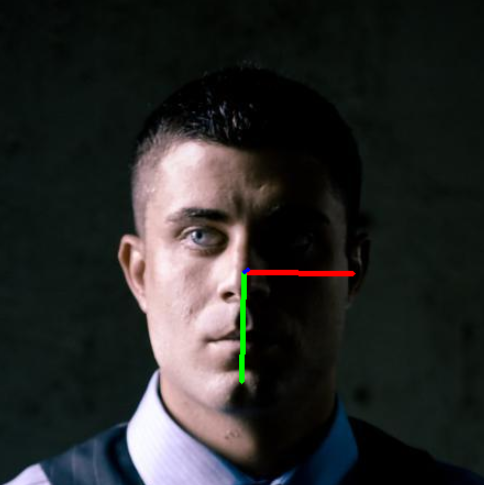






In [13]:
def draw_axes(img, labels, tdx, tdy):

  # the 3 axes
  pitch = labels[0]
  yaw = labels[1]
  roll = labels[2]

  # line size
  size = 100

  # inverted to not hide the face
  yaw = -yaw

  # X-Axis pointing to right. drawn in red
  x1 = size * (cos(yaw) * cos(roll)) + tdx
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

  # Y-Axis | drawn in green
  #        v
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
  y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

  # Z-Axis (out of the screen) drawn in blue
  x3 = size * (sin(yaw)) + tdx
  y3 = size * (-cos(yaw) * sin(pitch)) + tdy

  # drowing the 3 axes
  cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
  cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
  cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

  return img

In [14]:
def final_model(img):

  # retrieve the normalized image
  norm_image, center_x, center_y = mediapipe2array(img)
  norm_image = norm_image.reshape(1,-1)

  # test the model if we have all the points
  if norm_image.shape[1] == 936:

    # predict the axes
    y_pred = svr.predict(norm_image)[0]
  
    # draw the axes on the image
    return draw_axes(img, y_pred,center_x, center_y)
  
  # don't drow axes if miediapipe couldn't detect the whole face
  else: return draw_axes(img, [0,0,0],-5,-5)

# Test on Images

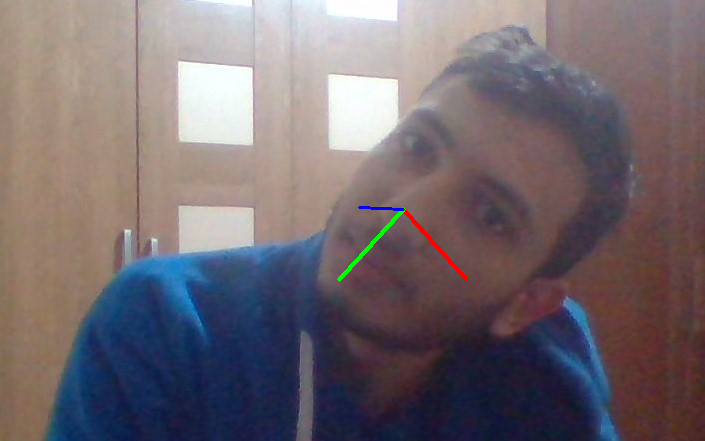

In [15]:
#pass the image path and enjoy the magic
image = cv2.imread('/content/WIN_20230217_16_36_16_Pro.jpg')
cv2_imshow(final_model(image))

# Video Show
Create a VideoCapture object and read from input file

In [16]:
def video_final_model(path):
  # creates object that converts video to frames
  cap = cv2.VideoCapture(path)

  # creates object that converts frames to video with 24 frame each second and has the same width and height as the original one
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 24, (width,height))

  #list of images
  frames = []

  # looping over the vieo frames
  while(cap.isOpened()):

    # retrieve the frame and boolien value that indecates the existance of the frame 'ret'
    ret, frame = cap.read()

    if ret == True:
      # process the image
      frames.append(final_model(frame))
    else: break

  # delete the object
  cap.release()
  cv2.destroyAllWindows()

  # compine the frames
  for i in range(len(frames)):
    out.write(frames[i])
  out.release()

  # download a copy of the video after processing it
  files.download('/content/out.mp4')

# Test on Videos

In [17]:
video_final_model('/content/WIN_20230217_16_36_19_Pro.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>